# Identifying Stations Clusters

Ideally, for our task we would predict the target on each individual station. However, due to the large number of stations, this would take quite a while and/or require unreasonable amounts of compute.

Therefore, our aim in this notebook is to find a reasonable amount (~5) of clusters of stations exhibiting similar usage patterns on which we will base our further modelling.

## Setup and Preparation

In [2]:
seed = 42

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, OPTICS
from sklearn.metrics import silhouette_score
from k_means_constrained import KMeansConstrained
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [4]:
# OPTIONAL CODE CHUNK TO BE EXECUTED ON WINDOWS ONLY
#import os
#os.environ["OMP_NUM_THREADS"] = "1"

In [5]:
df = pd.read_parquet("data/final/df.parquet")

In [8]:
stations_df = df.drop_duplicates(subset='station_name')
stations_df = stations_df.drop(columns=['has_kiosk', 'sum', 'station_name', 'latitude', 'longitude', 'hour', 'departures', 'arrivals', 'temperature_2m', 'weather_code', 'rain', 'precipitation', 'snowfall', 'cloud_cover', 'wind_gusts_10m', 'wind_speed_10m', 'sunrise', 'sunset', 'weather_cluster', 'isHoliday', 'weekday', 'night', 'workhours', 'commute', 'free', 'day', 'month', 'year', 'delta'])
# exclude variance features as they are generally very small and found to be detriemental in all cases
stations_df = stations_df.loc[:,~stations_df.columns.str.contains('^var', case=False)]

In [ ]:
stations_df.head()

,num_docks_available,num_bikes_available,num_ebikes_available,has_kiosk,capacity,avg_delta_station_total,avg_arrivals_station_total,avg_departures_station_total,avg_delta_station_night,avg_arrivals_station_night,...,avg_delta_station_unfriendly_weather,avg_arrivals_station_unfriendly_weather,avg_departures_station_unfriendly_weather,avg_sum_station,avg_sum_station_night,avg_sum_station_nonnight,avg_sum_station_holiday,avg_sum_station_commute,avg_sum_station_free,avg_sum_station_unfriendly_weather
0,1,12,6,YES,15,0.094006,1.396650,1.302644,-0.140687,0.240960,...,-0.083979,1.183463,1.267442,2.699294,0.622607,0.234822,2.660256,3.992523,2.487069,2.450904
8776,0,23,4,YES,23,0.316545,1.222197,0.905652,-0.118201,0.130356,...,0.179156,1.071059,0.891904,2.127849,0.378912,0.577393,1.721154,3.245124,1.812859,1.962963
17552,16,3,0,YES,19,0.021650,1.014585,0.992935,0.139775,0.414160,...,0.205919,1.080867,0.874948,2.007521,0.688545,-0.049225,1.637821,2.959688,1.892601,1.955815
26328,6,15,2,YES,23,0.039198,1.562671,1.523473,0.057733,0.380735,...,-0.069767,1.322136,1.391904,3.086144,0.703737,0.028077,2.176282,5.045514,2.455101,2.714040
35104,11,6,5,YES,19,-0.112808,0.308227,0.421035,-0.030690,0.094804,...,-0.100042,0.303043,0.403085,0.729262,0.220298,-0.162078,0.509615,1.038687,0.772270,0.706128


All of our features use for the clustering are numerical and we'll standardize them, in order to make the total space to be explored by the clustering algorithm smaller.

In [9]:
scaler = StandardScaler()
stations_df_scaled = scaler.fit_transform(stations_df)

### PCA

In order to pick up differences in the general usage-patterns of the stations, we include quite a lot of features in our clusterin, such as the maximum capacity of the stations and many aggregate usage scores, i.e., the number average of rentals/return in the night, during commute hours, on holidays, etc.
In order to make it easier for our algorithm to pick up clusters, we constrain the dimensionality of the space to explore by conducting a PCA and afterwards using the Principal Components for our cluster analysis:

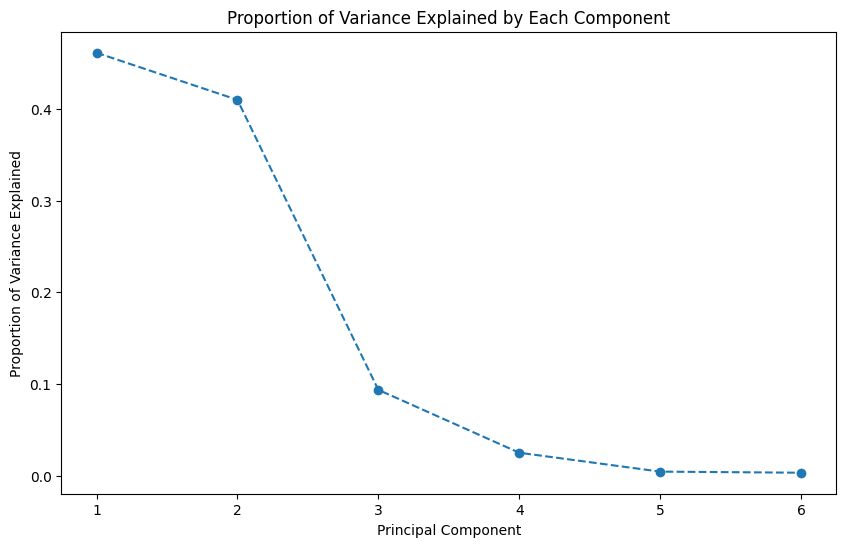

In [10]:
# We tried different numbers of components from 2-8, finding the end-results with 6 to be the most convincing.
pca = PCA(n_components=6)
X_pca = pca.fit_transform(stations_df)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 7), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title("Proportion of Variance Explained by Each Component")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.show()

We decided to include 6 principal components in the data, as nearly all variance in the data gets explained with them, allowing the clustering algorithm to hopefully find meaningful clusters, while at the same time reducing the dimensionality of the data significantly.

## Clustering

We try out different clustering algorithms for our goal. As this is more of an explorative endeavour, this process is not fully automated, but we manually exchanged parameters and reexecuted cells. Patterns that emerged during our analysis are contained in this notebook

We tried out the following clustering algorithms:

- KMeans
- DBSCAN
- HDBSCAN
- OPTICS
- KMeansContrained

While evaluating the results of clustering algorithms (especially in a complex space such as ours and with a high number of elements to cluster), is more of an art than an exact science, we used the following approach to decide which results seemed promising:

1. Plot different axis of the space spanned by the Principal Components against each other, visually determining whether the clusters identified by the algorithm are well separated.
2. By doing this, also determining whether or not the clusters have a reasonable size each - as our goal here is to pick up some shared structure between different stations in order to predict them together in our actual models, we ideally would like clusters that are as small as possible (in order to isolate shared properties), without having too many clusters that this exercise becomes pointless (as we'll need to run some models per cluster later on).
3. Additionally, or when the first step is inconclusive, we will also calculate the silouette score of the identified clusters.

### KMeans

We tried `n_clusters` ranging from 4 to 10.

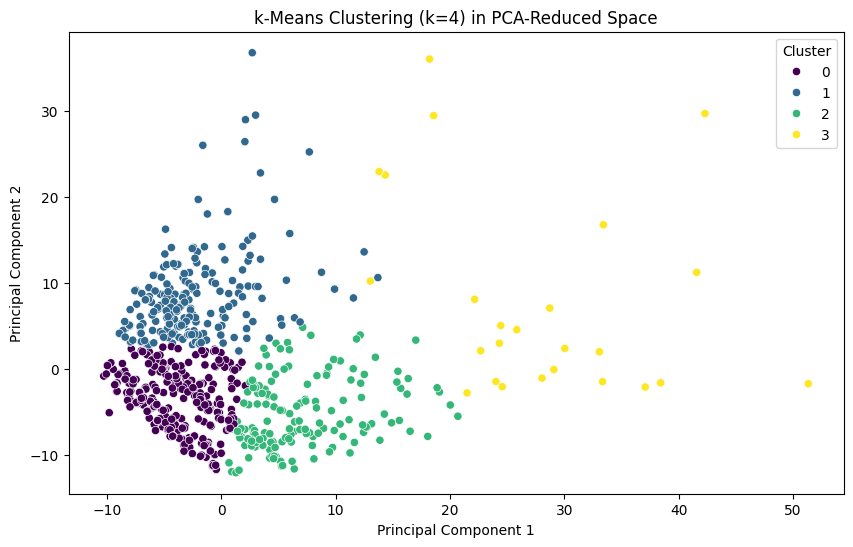

In [11]:
kmeans_full = KMeans(n_clusters=4, random_state = seed)
clusters_full = kmeans_full.fit_predict(X_pca)

plt.figure(figsize=(10, 6))
# Vary the dimensions of the PC plotted against each other here in order to get a comprehensive picture!
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_full, palette='viridis')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("k-Means Clustering (k=4) in PCA-Reduced Space")
plt.legend(title="Cluster")
plt.show()

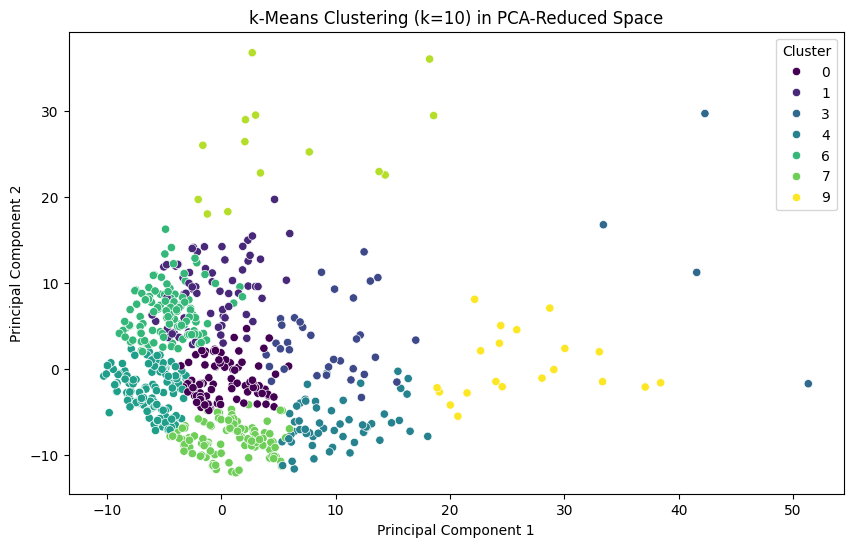

In [12]:

kmeans = KMeans(n_clusters=10, random_state = seed)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("k-Means Clustering (k=10) in PCA-Reduced Space")
plt.legend(title="Cluster")
plt.show()

We see that for higher values values of `k`, the algorithm is no longer able to separate the initial number of cluster, resulting in some clusters collapsing into one. The clusters identified with `k=4` are also already quite unbalanced.

As these results are unsatisfactory, we proceed with more complex algorithms:

### DBSCAN

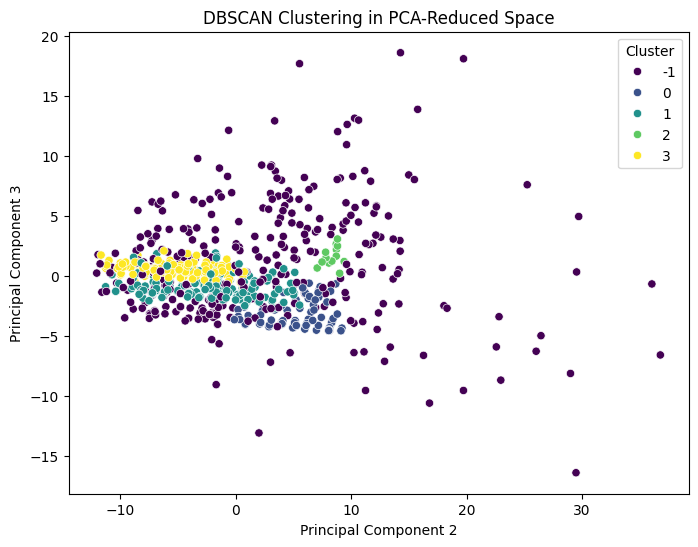

In [13]:
# Varying `min_samples` and `eps`
dbscan = DBSCAN(min_samples=10, eps=2)
clusters_db = dbscan.fit(X_pca)
clusters_db.labels_
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=clusters_db.labels_, palette='viridis')
plt.xlabel("Principal Component 2")
plt.ylabel("Principal Component 3")
plt.title("DBSCAN Clustering in PCA-Reduced Space")
plt.legend(title="Cluster")
plt.show()

The clusters seem promising, but are extremely unbalanced (see Cluster 3). As we can also see, that the density of the data points varies drastically, we'll try `HDBSCAN` and `OPTICS`:

### HDBSCAN

This also gives us the option to constrain cluster size. By limiting the size of the cluster we can guarantee that they are small enough to meaningfully benefit from this when predicting later on.

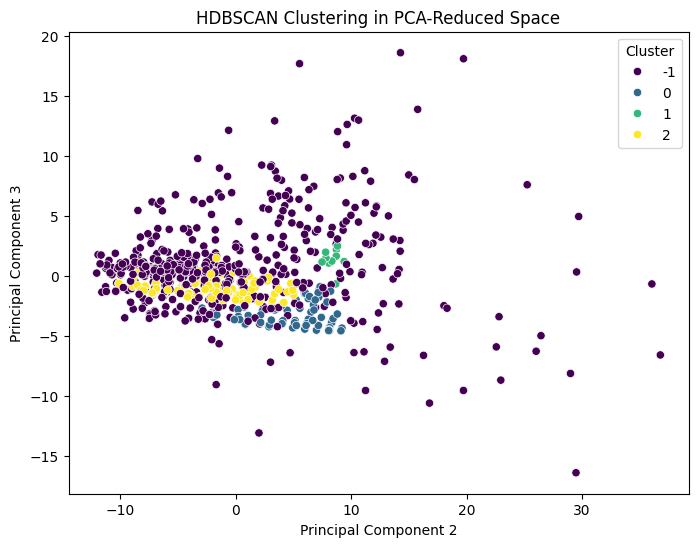

In [14]:
# Varying `min_cluster_size` and `cluster_selection_epsilon`
hdbscan = HDBSCAN(min_cluster_size=10, max_cluster_size=100, cluster_selection_epsilon=2)
clusters_hdb = hdbscan.fit(X_pca)
clusters_hdb.labels_
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=clusters_hdb.labels_, palette='viridis')
plt.xlabel("Principal Component 2")
plt.ylabel("Principal Component 3")
plt.title("HDBSCAN Clustering in PCA-Reduced Space")
plt.legend(title="Cluster")
plt.show()

### OPTICS

While we find nice clusters, we were not able to identify a reasonable number of them - with either very few or, with only slight changes in the parameters, drastically more than 10 clusters being assigned.

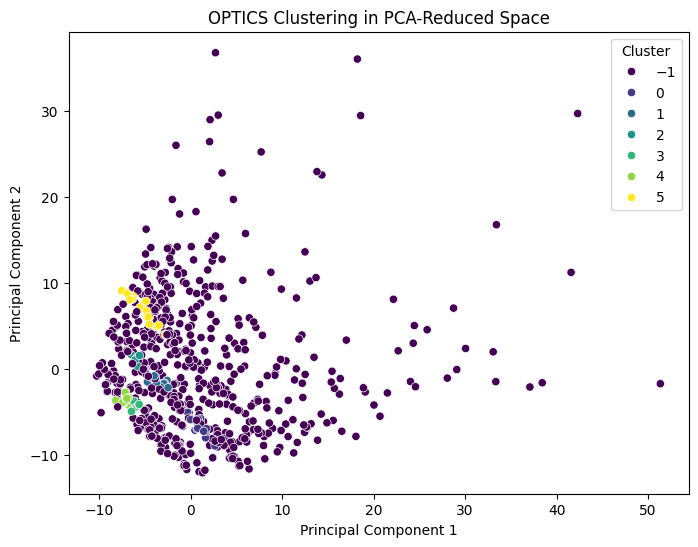

In [15]:
optics = OPTICS(min_samples=12)
clusters_opt = optics.fit_predict(X_pca)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_opt, palette='viridis')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("OPTICS Clustering in PCA-Reduced Space")
plt.legend(title="Cluster")
plt.show()

### KMeansConstrained

None of the "free-floating" algorithms resulted in clusters that we deemed useful for our goals. Our aim here is a bit unusual as we are not only interested in finding well-behaved and informative clusters, but also have strong constraints on the sizes of these clusters, as we need to significtantly reduce the numer of models to estimate in our main project.

Therefore, we try out a contrained version of `KMeans` next, that puts hard upper and lower limits on the sizes of the identified clusters, trying out different values. While this will necessary be detriemental to the conformity of the stations put in one cluster, having the clusters at all is more of a band-aid to a practical problem - as long as our final predictions have an okay, quality, low exlanability of the clusters is okay, as in an ideal world the prediction would happen at station level:

In [16]:
kmconst= KMeansConstrained(
    n_clusters=5,
    size_min=30,
    size_max=150,
    random_state = seed
)
kmconst_predictions = kmconst.fit_predict(X_pca)
silhouette_kmconst = silhouette_score(X_pca, kmconst_predictions)
print("Silhouette Score:", silhouette_kmconst)

Silhouette Score: 0.18522742089502492


In [17]:
kmconst= KMeansConstrained(
    n_clusters=10,
    size_min=30,
    size_max=150,
    random_state = seed
)
kmconst_predictions = kmconst.fit_predict(X_pca)
silhouette_kmconst = silhouette_score(X_pca, kmconst_predictions)
print("Silhouette Score:", silhouette_kmconst)


Silhouette Score: 0.2561339514896412


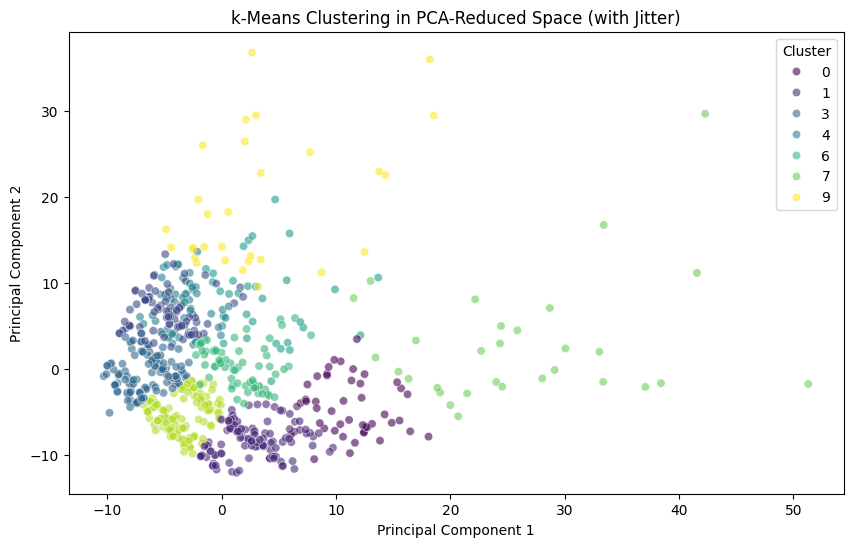

In [18]:
# more involved visualization as this algorithm is our last resort
jitter_strength = 0.02
X_pca_jittered = X_pca + np.random.normal(0, jitter_strength, X_pca.shape)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca_jittered[:, 0], 
    y=X_pca_jittered[:, 1], 
    hue=kmconst_predictions, 
    palette='viridis', 
    alpha=0.6
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("k-Means Clustering in PCA-Reduced Space (with Jitter)")
plt.legend(title="Cluster")
plt.show()

Graphically, while we do not get perfectly balanced clusters, we can already see that we get clusters that a) are convincing when plotted and b) multiple of them have reasonable sized to work with. We go with the cluster seperation with a silouette score of 0.25, which is not great, but at least indicates weak structuring that allows us to proceed with our analysis:

Let's get an overview of the distribution of stations per cluster:

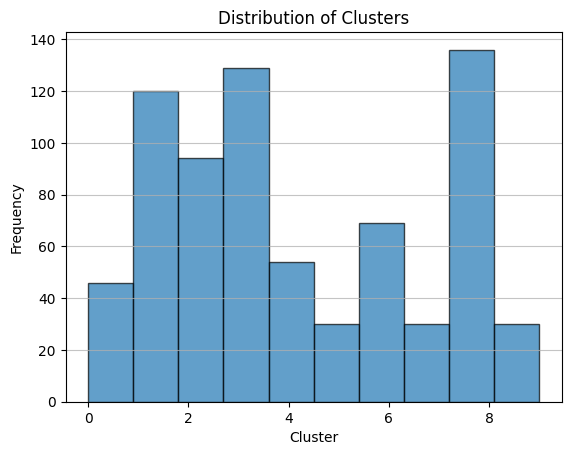

In [19]:
plt.hist(kmconst_predictions, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Clusters')
plt.grid(axis='y', alpha=0.75)
plt.show()

While we have some smaller clusters (5, 7, 9), we also have some quite large ones (1,2,3,8). Overall however, the number of clusters is manageable and we have no extremely small cluster. Also, substantively, it makes sense that there could be properties that identify a cluster that leads to smaller ones, e.g., one would expect there to be quite a few stations that are very active at night, that could end up in one cluster.

## Geographically Visualizing the Stations and their Clusters

As a last step, we will plot the stations on a map, colored by their cluster. Here, we ideally expect to see some geographical clustering as well, but no perfect geographical separation, as it is very sensible to assume that, e.g., in a business district, not all stations are used by commuters in the same way, but some are more utilized than others.

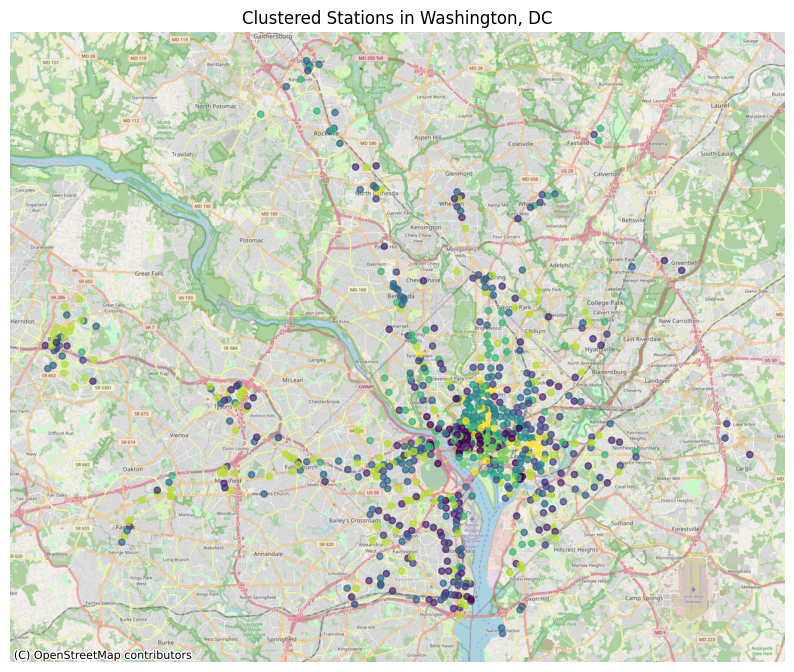

In [ ]:
# Data Preparation
###
stations_df = df.drop_duplicates(subset='station_name')
df_for_map = pd.DataFrame({
    "longitude": stations_df["longitude"],
    "latitude": stations_df["latitude"],
    "cluster": kmconst_predictions
})


geometry = [Point(xy) for xy in zip(df_for_map['longitude'], df_for_map['latitude'])]
gdf = gpd.GeoDataFrame(df_for_map, geometry=geometry, crs="EPSG:4326")
# Reproject to Web Mercator for plotting
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='cluster', cmap='viridis', markersize=20, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
plt.title('Clustered Stations in Washington, DC')
plt.axis('off')
plt.savefig('figures/cluster_on_map.png', dpi=300, bbox_inches='tight')
plt.show()


## Add Clustering to Unified Data file

In [ ]:
# TODO: FIXUP
df = pd.read_parquet("data/final/df.parquet")
stations_df = df.drop_duplicates(subset='station_name')
clustering_stations = pd.DataFrame({
    'cluster': kmconst_predictions,
    'station_name': stations_df["station_name"],
})
new_df = pd.merge(df, clustering_stations, on="station_name")